In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


In [2]:
# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 15
DATA_DIR = r"C:\Users\Cherilyn\Desktop\trash_sort\src\data\trashnet"
MODEL_PATH = 'models/trashsort_cnn.h5'

In [3]:
# Verify current working directory (optional)
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Cherilyn\Desktop\trash_sort\src


In [4]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get class names from generator
CLASS_NAMES = list(train_gen.class_indices.keys())
print("Detected classes:", CLASS_NAMES)

Found 1914 images belonging to 5 classes.
Found 476 images belonging to 5 classes.
Detected classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [5]:
# Build model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


In [6]:
# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

c:\Users\Cherilyn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.4190 - loss: 1.5131 - val_accuracy: 0.6471 - val_loss: 0.9059
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - accuracy: 0.7037 - loss: 0.7874 - val_accuracy: 0.6849 - val_loss: 0.8123
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step - accuracy: 0.7438 - loss: 0.6373 - val_accuracy: 0.7290 - val_loss: 0.7049
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 375ms/step - accuracy: 0.7903 - loss: 0.5633 - val_accuracy: 0.7311 - val_loss: 0.7072
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.8171 - loss: 0.4796 - val_accuracy: 0.7395 - val_loss: 0.6687
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - accuracy: 0.8351 - loss: 0.4439 - val_accuracy: 0.7458 - val_loss: 0.6819
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.8358 - loss: 0.4349 - val_accuracy: 0.7542 - val_loss: 0.7027
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - accuracy: 0.8482 - loss: 0.4211 - val_accu

In [7]:
# Save model
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
model.save(MODEL_PATH)

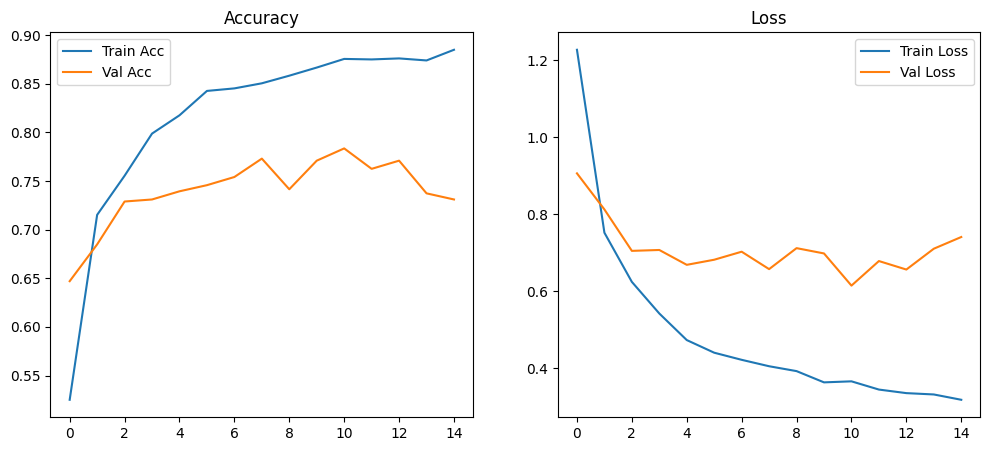

In [8]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.savefig('training_history.png')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step


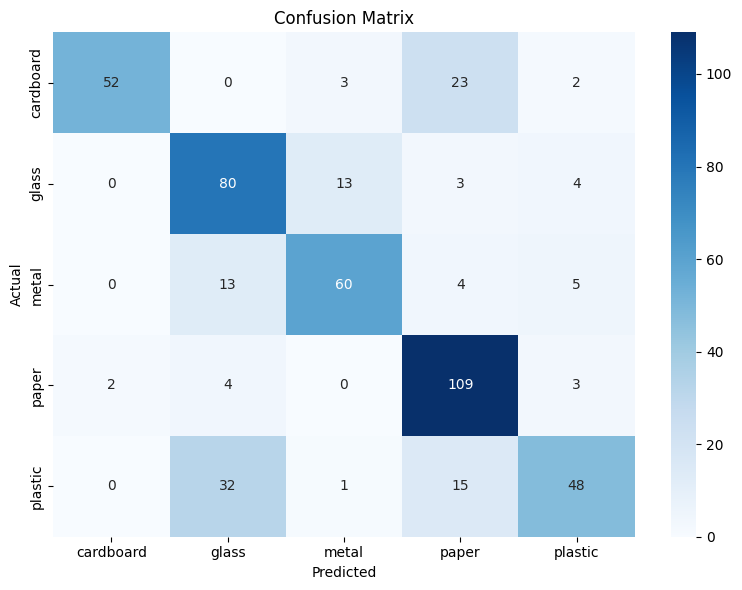

In [9]:
# Confusion Matrix
val_gen.reset()
Y_pred = model.predict(val_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [10]:
# Print classification report
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

   cardboard       0.96      0.65      0.78        80
       glass       0.62      0.80      0.70       100
       metal       0.78      0.73      0.75        82
       paper       0.71      0.92      0.80       118
     plastic       0.77      0.50      0.61        96

    accuracy                           0.73       476
   macro avg       0.77      0.72      0.73       476
weighted avg       0.76      0.73      0.73       476

